Import packages

In [2]:
import env_methods as em
import vis_methods as vis
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import numpy as np
import datetime as dt
import math

Basic Parameters

In [3]:
#Define bounding box in North America
lat_start = 0
lat_end = 90
lon_start = -179
lon_end =  -30

#Data paths
main_path = r'C:\Users\bpara\Geo data'

temps_path = r'\temp'
geomean_path = r'\geopotential mean'
rain_path = r'\surface precip'
snow_path = r'\snow depth'
moisture_path = r'\soil moisture'
shum_path = r'\specific humidity'

#Visualization labels:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

Import data

In [4]:
temp_data = em.get_data(main_path+temps_path, True)
temp_data["air"]=temp_data["nc_vars"].pop("air") #remove stacked structure
temp_data.pop("nc_vars")

geomean_data = em.get_data(main_path+geomean_path, True)
geomean_data["hgt"]=geomean_data["nc_vars"].pop("hgt")
geomean_data.pop("nc_vars")

rain_data = em.get_data(main_path+rain_path, True)
rain_data["apcp"] = rain_data["nc_vars"].pop("apcp")
rain_data.pop("nc_vars")

snow_data = em.get_data(main_path+snow_path, True)
snow_data["snod"]=snow_data["nc_vars"].pop("snod")
snow_data.pop("nc_vars")

moisture_data = em.get_data(main_path+moisture_path, True)
moisture_data["soilm"] = moisture_data["nc_vars"].pop("soilm")
moisture_data.pop("nc_vars")

shum_data = em.get_data(main_path + shum_path, True)
shum_data["shum"] = shum_data["nc_vars"].pop("shum")
shum_data.pop("nc_vars")

acquring data from air.2m.mon.mean.nc
acquring data from hgt.mon.mean.nc
acquring data from apcp.mon.mean.nc
acquring data from snod.mon.mean.nc
acquring data from soilm.mon.mean.nc
acquring data from shum.mon.mean.nc


{}

Define a function to produce mean values for a given month over a given timespan. Start year is inclusive, end year is exclusive

In [6]:
#Data is dict with lat and lon keys for latitude and longitude observed, datakey as a key for a dataset, and time key for 
#when the data was taken. Month is month of interest, start and end years are the beginning and end (inclusive and exclusive)
#of the time range you want to look at. Lastly, the has_levels is a boolean of whether the dataset is monolevel, with the
#optional parameter of what level you want to look at.
#Returns a dict with lat, lon and mean keys

#sometimes all three of these generate functions that return dicts sometimes have an error pop up due to overflow or
#dividing by zero. Don't worry about that, it just means there is no data for a location, and it is uncolored on the resulting
#maps as a result

#(Dict, string, int, int, int, boolean, optional int) -> Dict
def generate_means(data, datakey, month, start_year, end_year, has_levels, level=0):
    start_time = dt.datetime(start_year, month, 1)
    end_time = dt.datetime(end_year, month, 1)
    start_index = em.find_closest_val(start_time, data["time"])
    end_index = em.find_closest_val(end_time, data["time"])
    #This pulls just the month of interest and makes an arraylike only containing that data
    dataset = data[datakey][start_index:end_index][::12] 

    means = dict()
    means["lon"] = data["lon"][:]
    means["lat"] = data["lat"][:]
    
    if has_levels:
        temp = np.copy(dataset)[0][level]
    else:
        temp = np.copy(dataset)[0]
    
    for year in dataset[1:]:
        if has_levels:
            temp+=year[:,:][level]
        else:
            temp+=year[:,:]
    temp = temp / (end_year - start_year)
    means["mean"] = np.copy(temp)
    return means

Define a function to produce (sample) standard deviation values for a given month over a given timespan. Start year is inclusive, end year is exclusive

In [7]:
#All parameters the same as above, returns a dict with lat, lon and stddev keys

#(Dict, string, int, int, int, boolean, optional int) -> Dict
def generate_stddev(data, datakey, month, start_year, end_year, has_levels, level=0):
    start_time = dt.datetime(start_year, month, 1)
    end_time = dt.datetime(end_year, month, 1)
    start_index = em.find_closest_val(start_time, data["time"])
    end_index = em.find_closest_val(end_time, data["time"])
    
    dataset = np.copy(data[datakey][start_index:end_index][::12])
    means = np.copy(generate_means(data, datakey, month, start_year, end_year, has_levels, level)["mean"])
    stddev = dict()
    stddev["lat"] = data["lat"][:]
    stddev["lon"] = data["lon"][:]
    
    if has_levels:
        temp = np.square(dataset[0][level]-means)
    else:
        temp = np.square(dataset[0]-means)
        
    for year in range(1, len(dataset)):
        if has_levels:
            temp+=np.square(dataset[year][level]- means)
        else:
            temp+=np.square(dataset[year]-means)
    temp = temp / (end_year - start_year - 1)
    temp = np.sqrt(temp)
    
    stddev["stddev"] = np.copy(temp)
    
    return stddev

Define a function to produce a z-score for each data point to tell how many standard deviations from the mean it is for a given month when compared to a given date range

In [8]:
#All parameters the same as above, returns a dict with lat, lon and score keys

#(Dict, string, int, int, int, boolean, optional int) -> Dict

def generate_z_score(data, datakey, month, start_year, end_year, focus_year, has_levels, level=0):
    focus_time = dt.datetime(focus_year, month, 1)
    focus_index = em.find_closest_val(focus_time, data["time"])
    
    means = np.copy(generate_means(data, datakey, month, start_year, end_year, has_levels, level)["mean"])
    stddevs = np.copy(generate_stddev(data, datakey, month, start_year, end_year, has_levels, level)["stddev"])
    
    z_score = dict()
    z_score["lon"] = data["lon"][:]
    z_score["lat"] = data["lat"][:]
    
    if has_levels:
        temp = np.copy(data[datakey][focus_index][level])
    else:
        temp = np.copy(data[datakey][focus_index])
    temp = temp - means
    temp = temp / stddevs
    
    z_score["score"] = np.copy(temp)
    
    return z_score

In [9]:
#Creates and saves a plot showing 6 months of anomaly data for the given data set. fname is the file name to save, scalebar 
#and title are strings representing the labels for the title and scalebar. Data is a dict with lat and lon keys (representing)
#the latitude and longitude of the data), as well as a key given by datakey for what the data is. Start year and end year
#are ranges over which you're finding mean data, they're inclusive and exclusive respectively. Focus year and focus month
#is the first month of data out of 6 you want to display, and there is a boolean for if the dataset is not monolevel

#optional parameters to focus in on a specific geographic bounding box, as well as change the min an max values of the scalebar

#(string, string, string, dict, strong, int, int, int, int, boolean) -> null (generates plot and saves file, but doesn't return)
#all optional parameters are ints
def generate_six_month_plot(fname, scalebar, title, data, datakey, start_year, end_year, focus_year, focus_month, 
                            has_levels, level=0, 
                           lon_min = 0, lon_max = 359, lat_min = -90, lat_max = 90, 
                            scale_min = -3, scale_max = 3):
    
    lat1 = em.find_closest_val(lat_min, data["lat"])
    lat2 = em.find_closest_val(lat_max, data["lat"])
    
    mesh = None
    
    fig, axs = plt.subplots(2,3, figsize=(30, 12), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 0)})
    for x in range(len(axs)):
        for y in range(len(axs[x])):
            axs[x][y].coastlines()
            axs[x][y].add_feature(cartopy.feature.LAKES, alpha=1)
            axs[x][y].add_feature(cartopy.feature.RIVERS, alpha = 1)
            axs[x][y].set_extent((lon_min, lon_max, lat_min, lat_max))
            axs[x][y].set_xticks(data["lon"][math.ceil(lon_min / 10) * 10:lon_max][::20], crs = ccrs.PlateCarree())
            axs[x][y].set_yticks(data["lat"][math.ceil(lat1 / 10) * 10:lat2][::20], crs = ccrs.PlateCarree())
            axs[x][y].set_title(months[(focus_month + 3*x+y - 1) % 12])
             
            plot_data = generate_z_score(data, datakey, (focus_month + 3*x+y - 1) % 12 + 1, 
                                         start_year, end_year, focus_year + math.floor((focus_month + 3*x+y - 1) / 12), 
                                               has_levels, level)
            
            mesh = axs[x][y].pcolor(plot_data["lon"][lon_min:lon_max], 
                              plot_data["lat"][lat1:lat2], 
                              plot_data["score"][lat1:lat2, lon_min:lon_max], 
                                    cmap="coolwarm", vmin =-scale_min, vmax = scale_max, shading = "nearest")
            
            
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    bar = fig.colorbar(mesh, cax=cbar_ax)
    bar.set_label(scalebar)
    
    fig.suptitle(title)
    
    plt.savefig(fname)

Below is just me calling a couple of the methods I've written above as an example

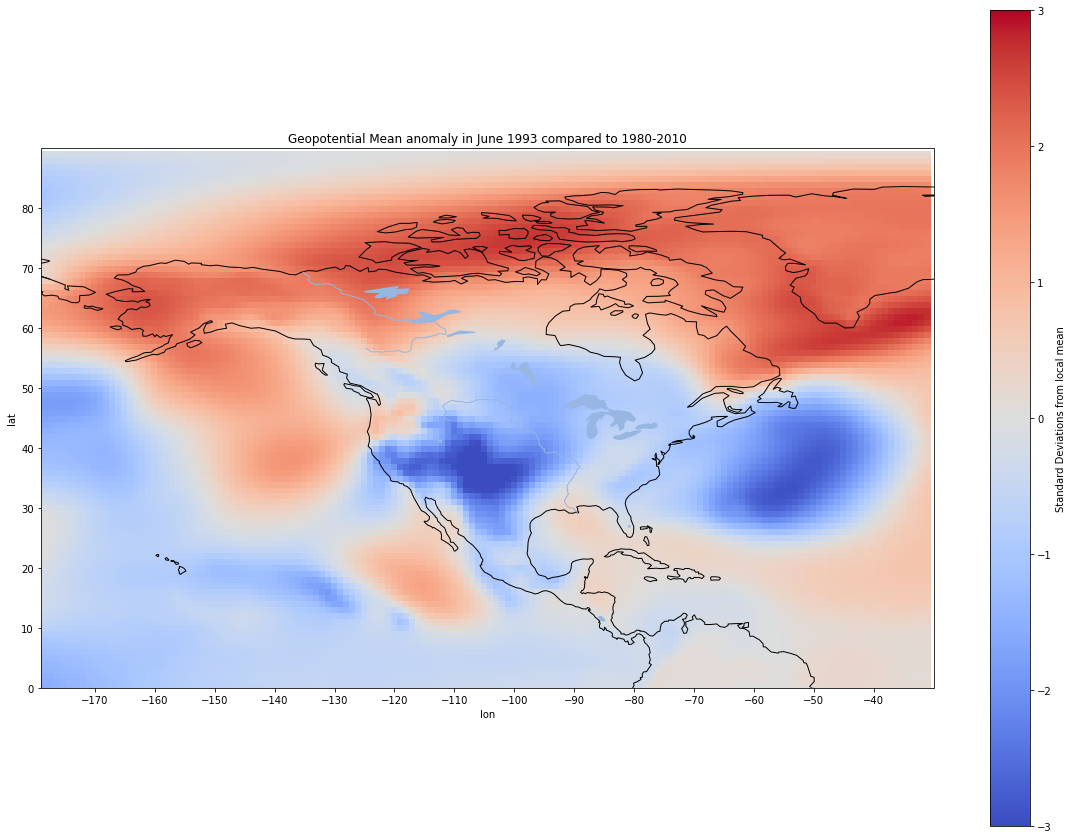

In [11]:
geo_z_score = generate_z_score(geomean_data, "hgt", 7, 1980, 2010, 1993, True, 0)


vis.plot_data(geo_z_score["lon"], geo_z_score["lat"], geo_z_score["score"], 
              "Standard Deviations from local mean", "Geopotential Mean anomaly in June 1993 compared to 1980-2010", 
              has_scale_bounds = True, scale_min = -3, scale_max = 3, 
              lon_min = lon_start, lon_max = lon_end, lat_min = lat_start, lat_max = lat_end)

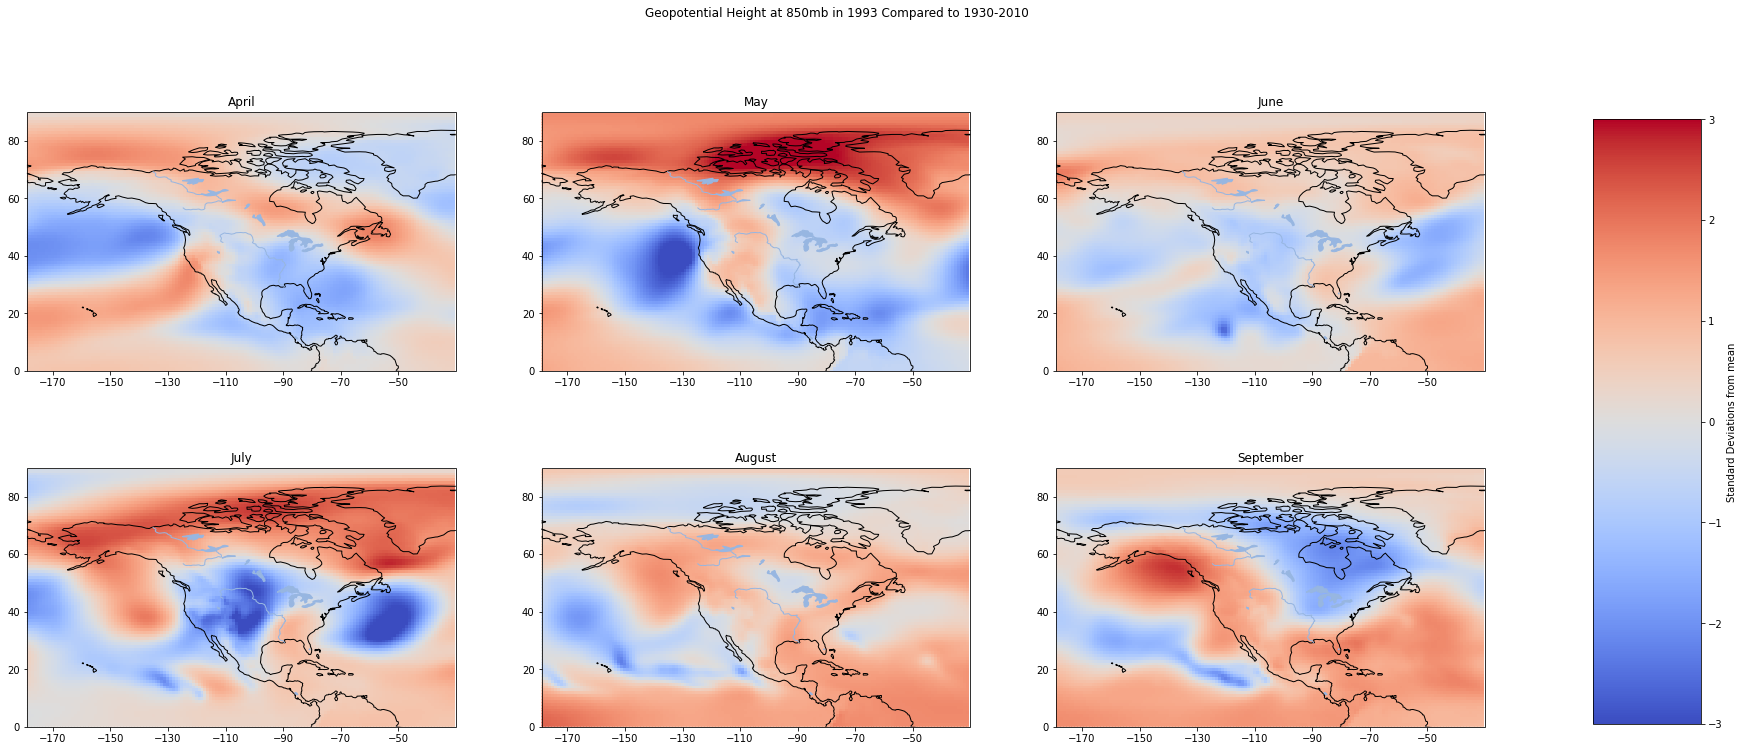

In [12]:
generate_six_month_plot("geopotential 850mb 1993.png", "Standard Deviations from mean", "Geopotential Height at 850mb in 1993 Compared to 1930-2010",
                        geomean_data, "hgt", 1930, 2010, 1993, 4, has_levels=True, level = 1, lon_min = lon_start, lon_max = lon_end, 
                        lat_min = lat_start, lat_max = lat_end, scale_min = 3, scale_max = 3)

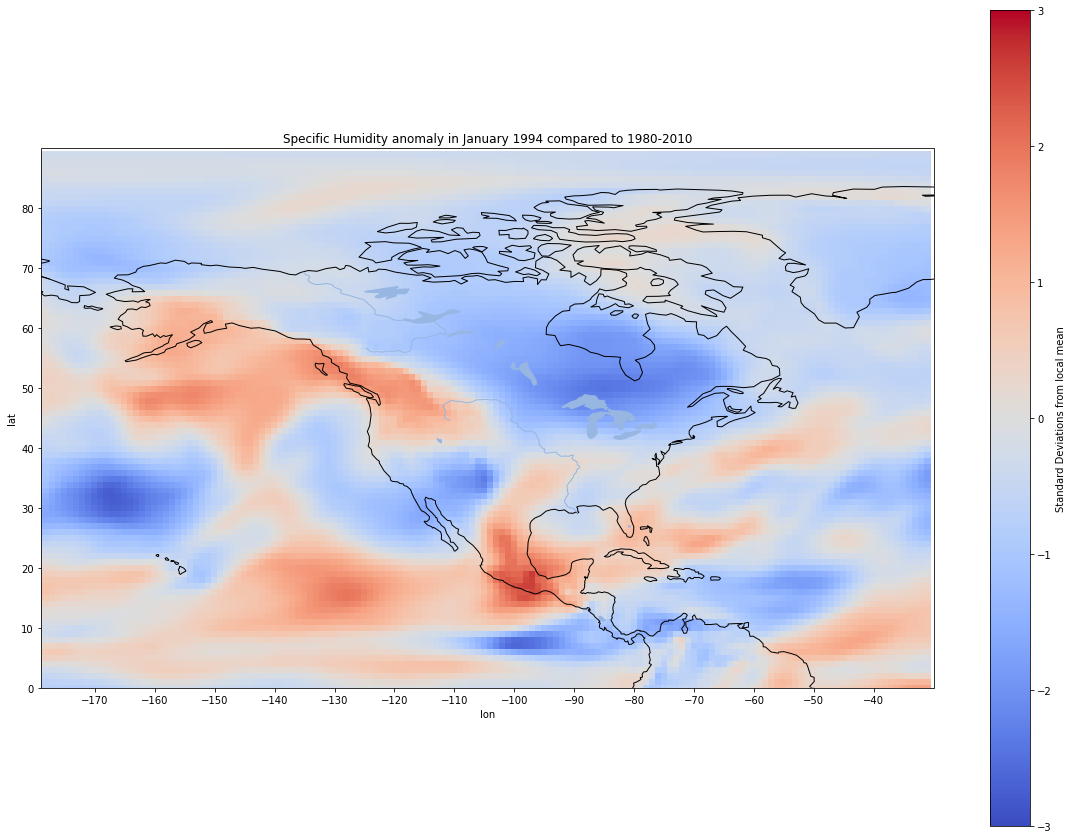

In [13]:
shum_z_score = generate_z_score(shum_data, "shum", 1, 1980, 2010, 1994, True, 1)

vis.plot_data(shum_z_score["lon"], shum_z_score["lat"], shum_z_score["score"], 
              "Standard Deviations from local mean", "Specific Humidity anomaly in January 1994 compared to 1980-2010",
              has_scale_bounds = True, scale_min = -3, scale_max = 3, 
              lon_min = lon_start, lon_max = lon_end, lat_min = lat_start, lat_max = lat_end)